# 1. Verificamos la integridad de los datos

In [53]:
import pandas as pd

#Cargamos los datos y visualizamos los primeros
datos=pd.read_excel("E-Commerce_train.xlsx")
datos.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


Exploramos los datos en busca de valores faltantes

In [54]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8999 non-null   int64 
 1   Warehouse_block      8999 non-null   object
 2   Mode_of_Shipment     8999 non-null   object
 3   Customer_care_calls  8999 non-null   int64 
 4   Customer_rating      8999 non-null   int64 
 5   Cost_of_the_Product  8999 non-null   int64 
 6   Prior_purchases      8999 non-null   int64 
 7   Product_importance   8999 non-null   object
 8   Gender               8999 non-null   object
 9   Discount_offered     8999 non-null   int64 
 10  Weight_in_gms        8999 non-null   int64 
 11  Reached.on.Time_Y.N  8999 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 843.8+ KB


Al parecer no tenemos ningún valor faltante, pero vamos a ver si es que los datos contenidos en las columnas corresponden a los que nos indican en la descripción de sus dimensiones. Y de paso separamos los campos nominales

In [55]:
nominales=["Warehouse_block","Mode_of_Shipment","Product_importance","Gender"]

for i in nominales:
    print(datos[i].value_counts())

F    2999
D    1500
A    1500
B    1500
C    1500
Name: Warehouse_block, dtype: int64
Ship      6122
Flight    1447
Road      1430
Name: Mode_of_Shipment, dtype: int64
low       4308
medium    3858
high       833
Name: Product_importance, dtype: int64
F    4540
M    4459
Name: Gender, dtype: int64


Efectivamente corresponden a lo que se nos indicó que contenía cada columna

In [56]:
datos.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,8999.00000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000
mean,4500.00000,4.015113,2.994999,208.561507,3.511501,15.097678,3584.364596,0.635515
std,2597.93187,1.138934,1.413143,48.289172,1.532074,17.400040,1614.750194,0.481312
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2250.50000,3.000000,2.000000,168.000000,3.000000,4.000000,1857.000000,0.000000
50%,4500.00000,4.000000,3.000000,211.000000,3.000000,8.000000,4046.000000,1.000000
75%,6749.50000,5.000000,4.000000,249.500000,4.000000,19.000000,4999.500000,1.000000
max,8999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Analizaremos ahora por entradas duplicadas

In [57]:
datos[datos.duplicated()]

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N


Los datos se encuentran en buen estado y según lo indicado. No se encuentra ningún valor duplicado, por lo tanto podemos seguir trabajando.

Primero haciendo un histograma con los valores númericos

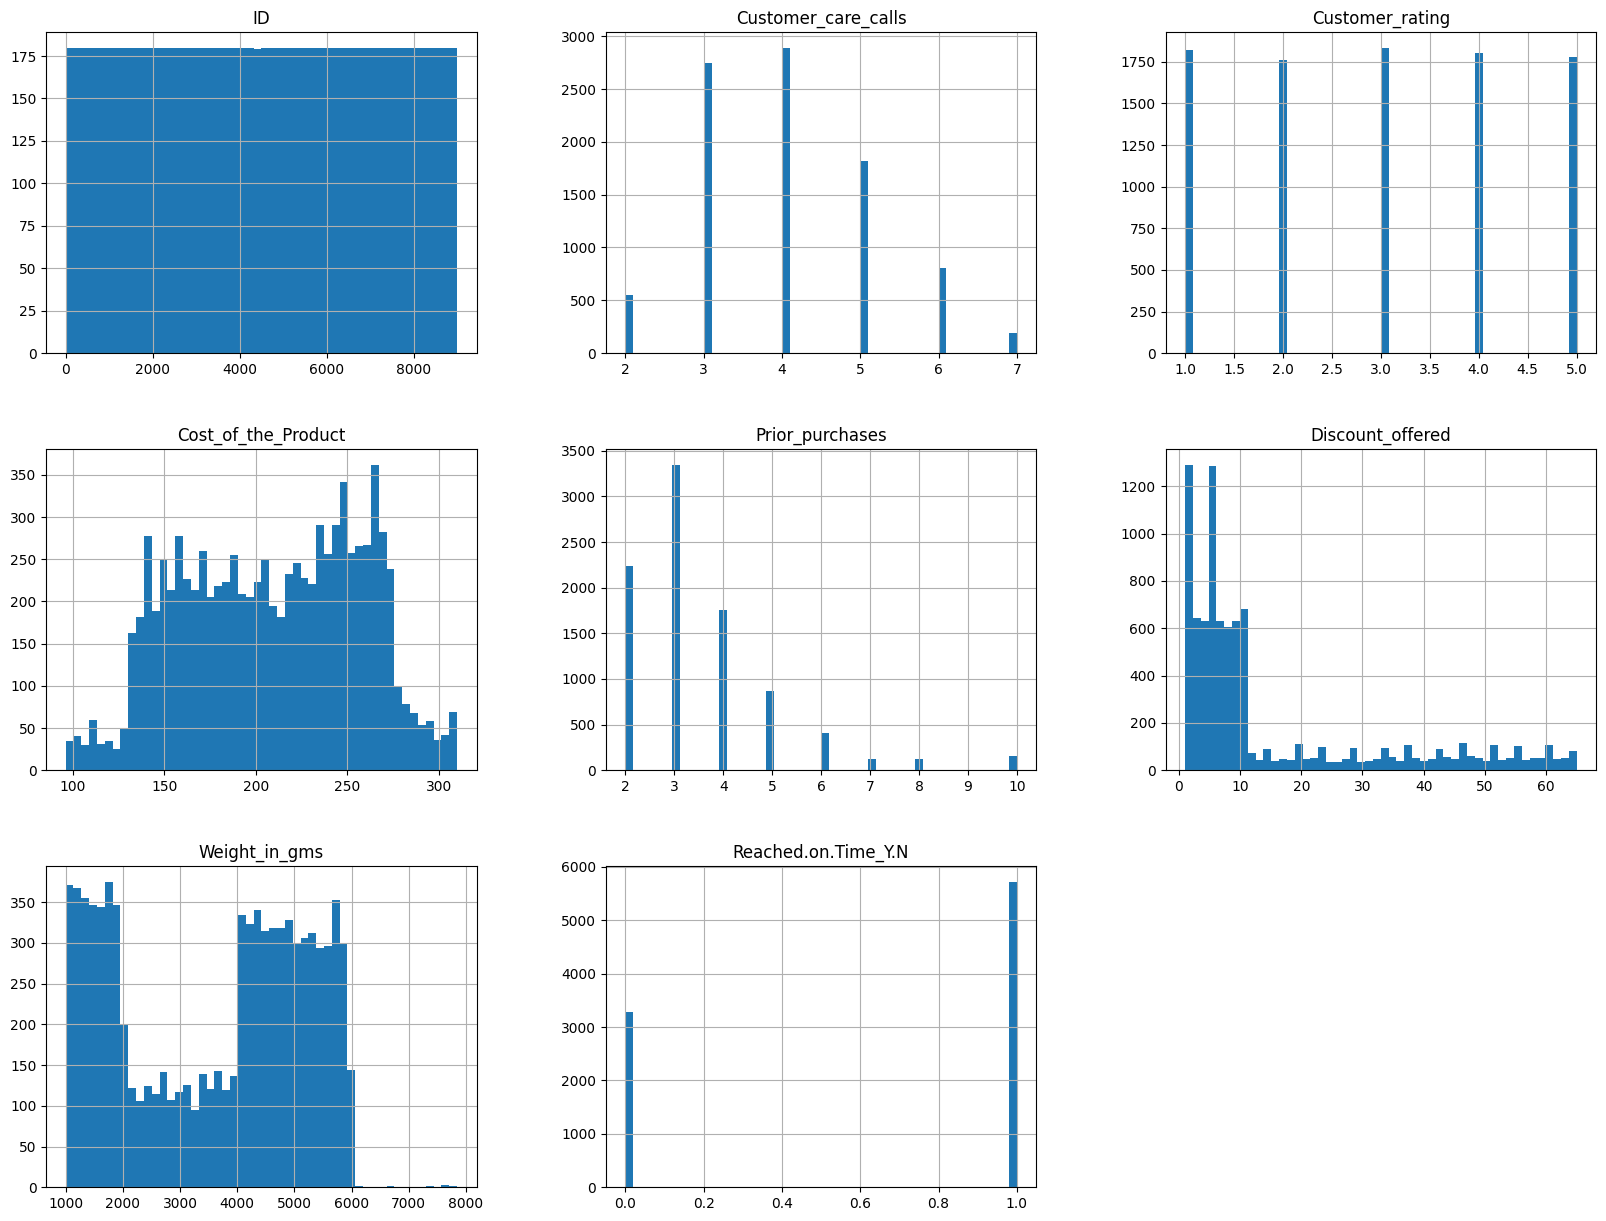

In [58]:
import matplotlib.pyplot as plt
datos.hist(bins=50, figsize=(20,15))
plt.show()

Es seguro que el dato de ID, no nos va a ser de utilidad para predecir si el envío llegó a tiempo o no así que podemos deshacernos de esa columna ahora mismo. Además de su poca variabilidad.

La cantidad de estrellas de los productos tiene muy poca varianza entre si, por lo que es poco probable que nos sirva de indicadora para nuestra variable objetivo. Así que, junto con la columna de género se postulan como candidatas a ser eliminadas.

In [59]:
datos.drop(columns="ID",inplace=True)

Al parecer en Weigh in grams tenemos valores atípicos, por lo que vamos a analizar la columna en profundidad

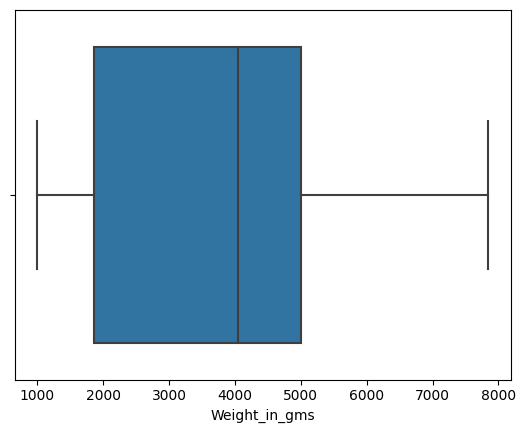

In [60]:
import seaborn as sns
sns.boxplot(x='Weight_in_gms', data=datos)
plt.show()

Seleccionamos el método de los cuartiles para detección de outliers

In [61]:
Q1 = datos['Weight_in_gms'].quantile(0.25)
Q3 = datos['Weight_in_gms'].quantile(0.75)
IQR = Q3 - Q1
BS = Q3 + 1.5*IQR

datos[datos.Weight_in_gms>BS]

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N


Me falló el ojo XD No hay valores atípicos.

# Escalado normalización

Vamos a escalar los valores numericos por valores más chicos y homogeneos a modo de que sean más fáciles de analizar.

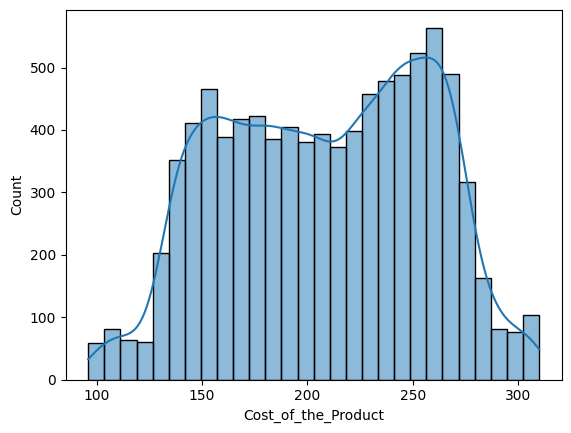

In [62]:
sns.histplot(x='Cost_of_the_Product', data=datos, kde=True)
plt.show()

In [63]:
from sklearn.preprocessing import MinMaxScaler

#instanciamos nuestro objeto con un rango de 1 a 10 ignorando la copia
scaler = MinMaxScaler(feature_range=(1,10), copy=False)

scaler.fit(datos[['Cost_of_the_Product']])

datos['Cost_of_the_Product'] = scaler.transform(datos[['Cost_of_the_Product']])

Volvemos a visualizar para comprobar que no hubo cambios en la forma de la distribución

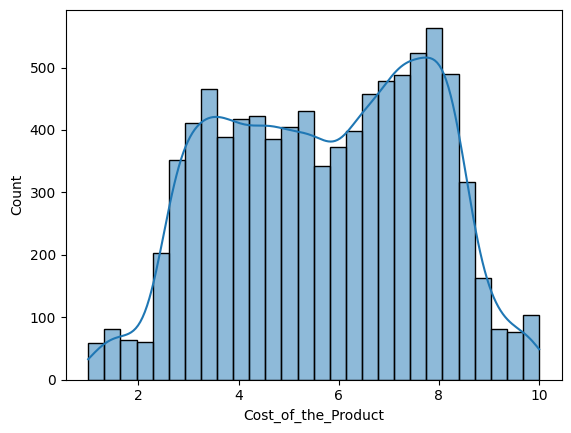

In [64]:
sns.histplot(x='Cost_of_the_Product', data=datos, kde=True)
plt.show()

Continuamos con el mismo procedimiento para nuestras otras variables numéricas

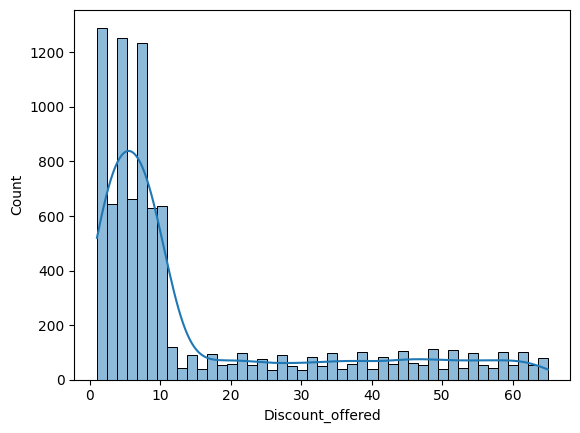

In [65]:
sns.histplot(x='Discount_offered', data=datos, kde=True)
plt.show()

In [66]:
datos['Discount_offered'].describe()

count    8999.000000
mean       15.097678
std        17.400040
min         1.000000
25%         4.000000
50%         8.000000
75%        19.000000
max        65.000000
Name: Discount_offered, dtype: float64

In [67]:
from sklearn.preprocessing import MinMaxScaler

# instanciamos nuestro objeto con un rango 
# correspondiende al del descuento ofrecido en tantos por uno, 
# ignorando la copia
scaler = MinMaxScaler(feature_range=(.01,.65), copy=False)

scaler.fit(datos[['Discount_offered']])

datos['Discount_offered'] = scaler.transform(datos[['Discount_offered']])

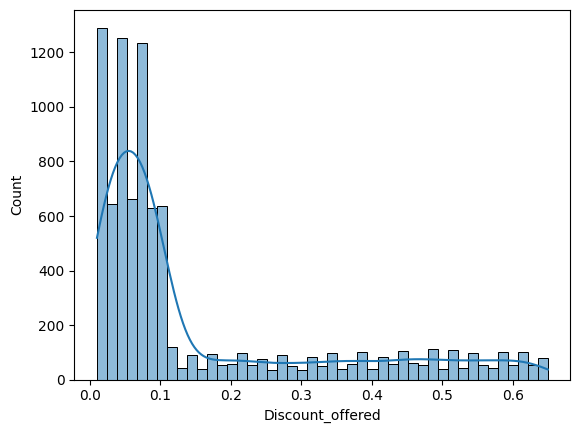

In [68]:
# Volvemos a visualizar nuestros datos
sns.histplot(x='Discount_offered', data=datos, kde=True)
plt.show()

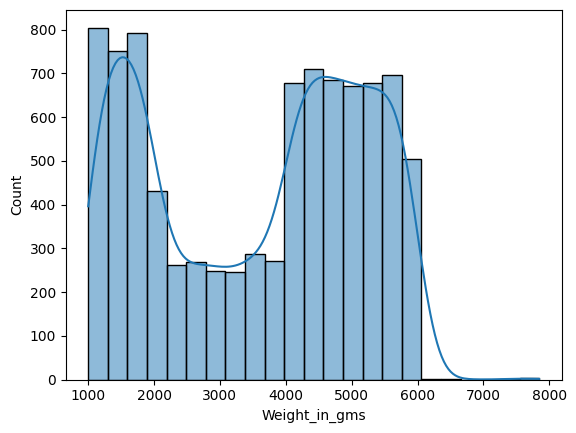

In [69]:
# Visualizamos los datos para el peso en gramos
sns.histplot(x='Weight_in_gms', data=datos, kde=True)
plt.show()

In [70]:
from sklearn.preprocessing import MinMaxScaler

# instanciamos nuestro objeto con un rango de 1 a 10
# ignorando la copia
scaler = MinMaxScaler(feature_range=(1,10), copy=False)

scaler.fit(datos[['Weight_in_gms']])

datos['Weight_in_gms'] = scaler.transform(datos[['Weight_in_gms']])

# Codificación de variables nominales

In [71]:
datos[nominales].head()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F


Descubrimos que lo mejor para las columnas Warehouse_block y  Mode_of_Shipment es un OneHotEscaler, Mientras que para el Product_importance y Gender lo mejor es un labelencoder.

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

datos['Gender'] = label_encoder.fit_transform(datos['Gender'])

In [ ]:
label_encoder.classes_

array(['F', 'M'], dtype=object)

Para asegurarnos que Label encoder asigne la importancia de productos siguiendo el orden low, medium, high. Descartamos el uso automático de la herramienta lo hacemos de forma manual, para Product_importance 

In [ ]:
datos['Product_importance'] = datos['Product_importance'].map({"low":0,"medium":1,"high":2})

One hot encoder para Warehouse_block y Mode_of_Shipment. De esta forma evitamos que se genere la falsa idea de que una casa de guardado o un modo de envío es más importante que otro

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# Alimentamos y transformamos los datos de dos columnas
data_encoded = ohe.fit_transform(datos[["Warehouse_block","Mode_of_Shipment"]]).toarray()


In [ ]:
ohe.categories_

[array(['A', 'B', 'C', 'D', 'F'], dtype=object),
 array(['Flight', 'Road', 'Ship'], dtype=object)]

In [ ]:
import numpy as np

# Convertimos las categorías en un array único
etiquetas= np.concatenate(ohe.categories_, axis=0)

In [ ]:
# Creamos el df a agregar al original
df_new_columns=pd.DataFrame(data_encoded,columns=etiquetas)

In [ ]:
df_new_columns

,A,B,C,D,F,Flight,Road,Ship
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
datos=pd.concat([datos,df_new_columns], axis=1)

Una vez concatenados los nuevos datos a nuestro df original podemos deshacernos de las columnas viejas que representaban esos datos

In [ ]:
datos.drop(columns=["Warehouse_block","Mode_of_Shipment"], inplace=True)

# Analizamos la correlación entre atributos

In [ ]:
correlacion = datos.corr()

correlacion["Reached.on.Time_Y.N"].sort_values(ascending=False)

Reached.on.Time_Y.N    1.000000
Discount_offered       0.416357
Product_importance     0.014361
Customer_rating        0.011045
Flight                 0.009057
B                      0.006646
Ship                   0.005633
D                      0.003548
Gender                 0.002881
C                     -0.000169
F                     -0.000935
A                     -0.008842
Road                  -0.016286
Prior_purchases       -0.048269
Customer_care_calls   -0.072261
Cost_of_the_Product   -0.083470
Weight_in_gms         -0.326877
Name: Reached.on.Time_Y.N, dtype: float64

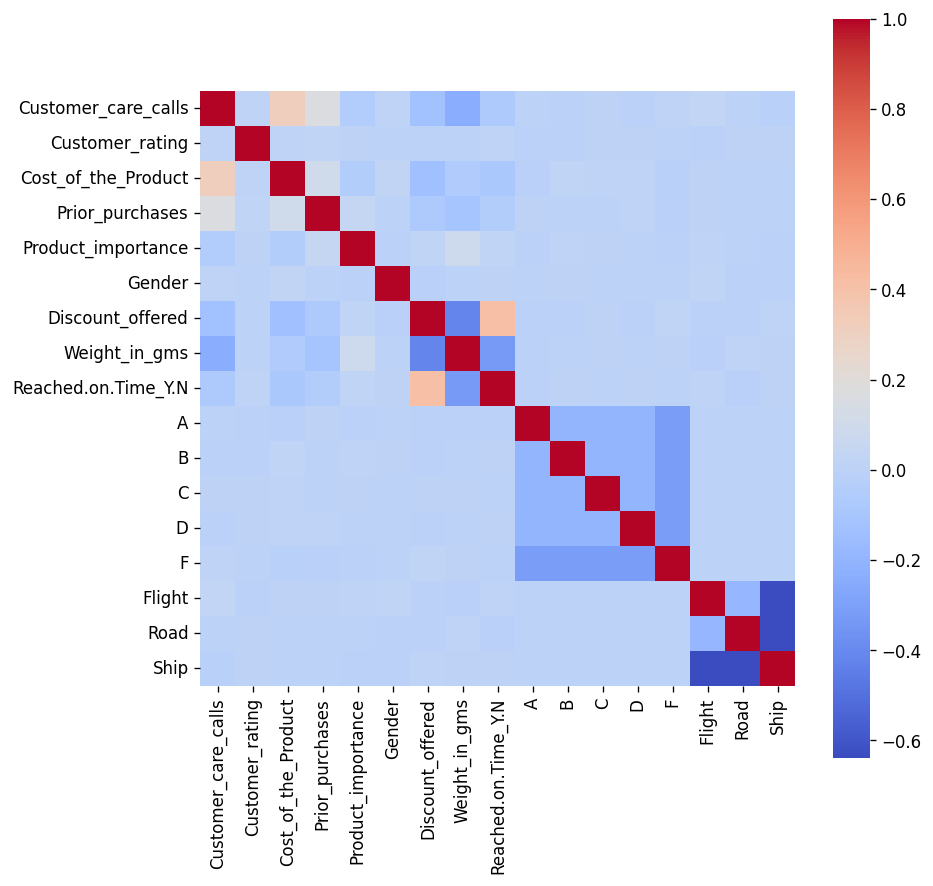

In [ ]:
# greamos un lienzo de 8x8 pulgagas y una densidad de pixeles de 80
figuras, ejes = plt.subplots(figsize=(8, 8), dpi=120)

# Dejamos que infiera los valores minimos y máximos (vmin ,vmax)
sns.heatmap(correlacion, square=True, cmap="coolwarm", ax=ejes)
plt.show()

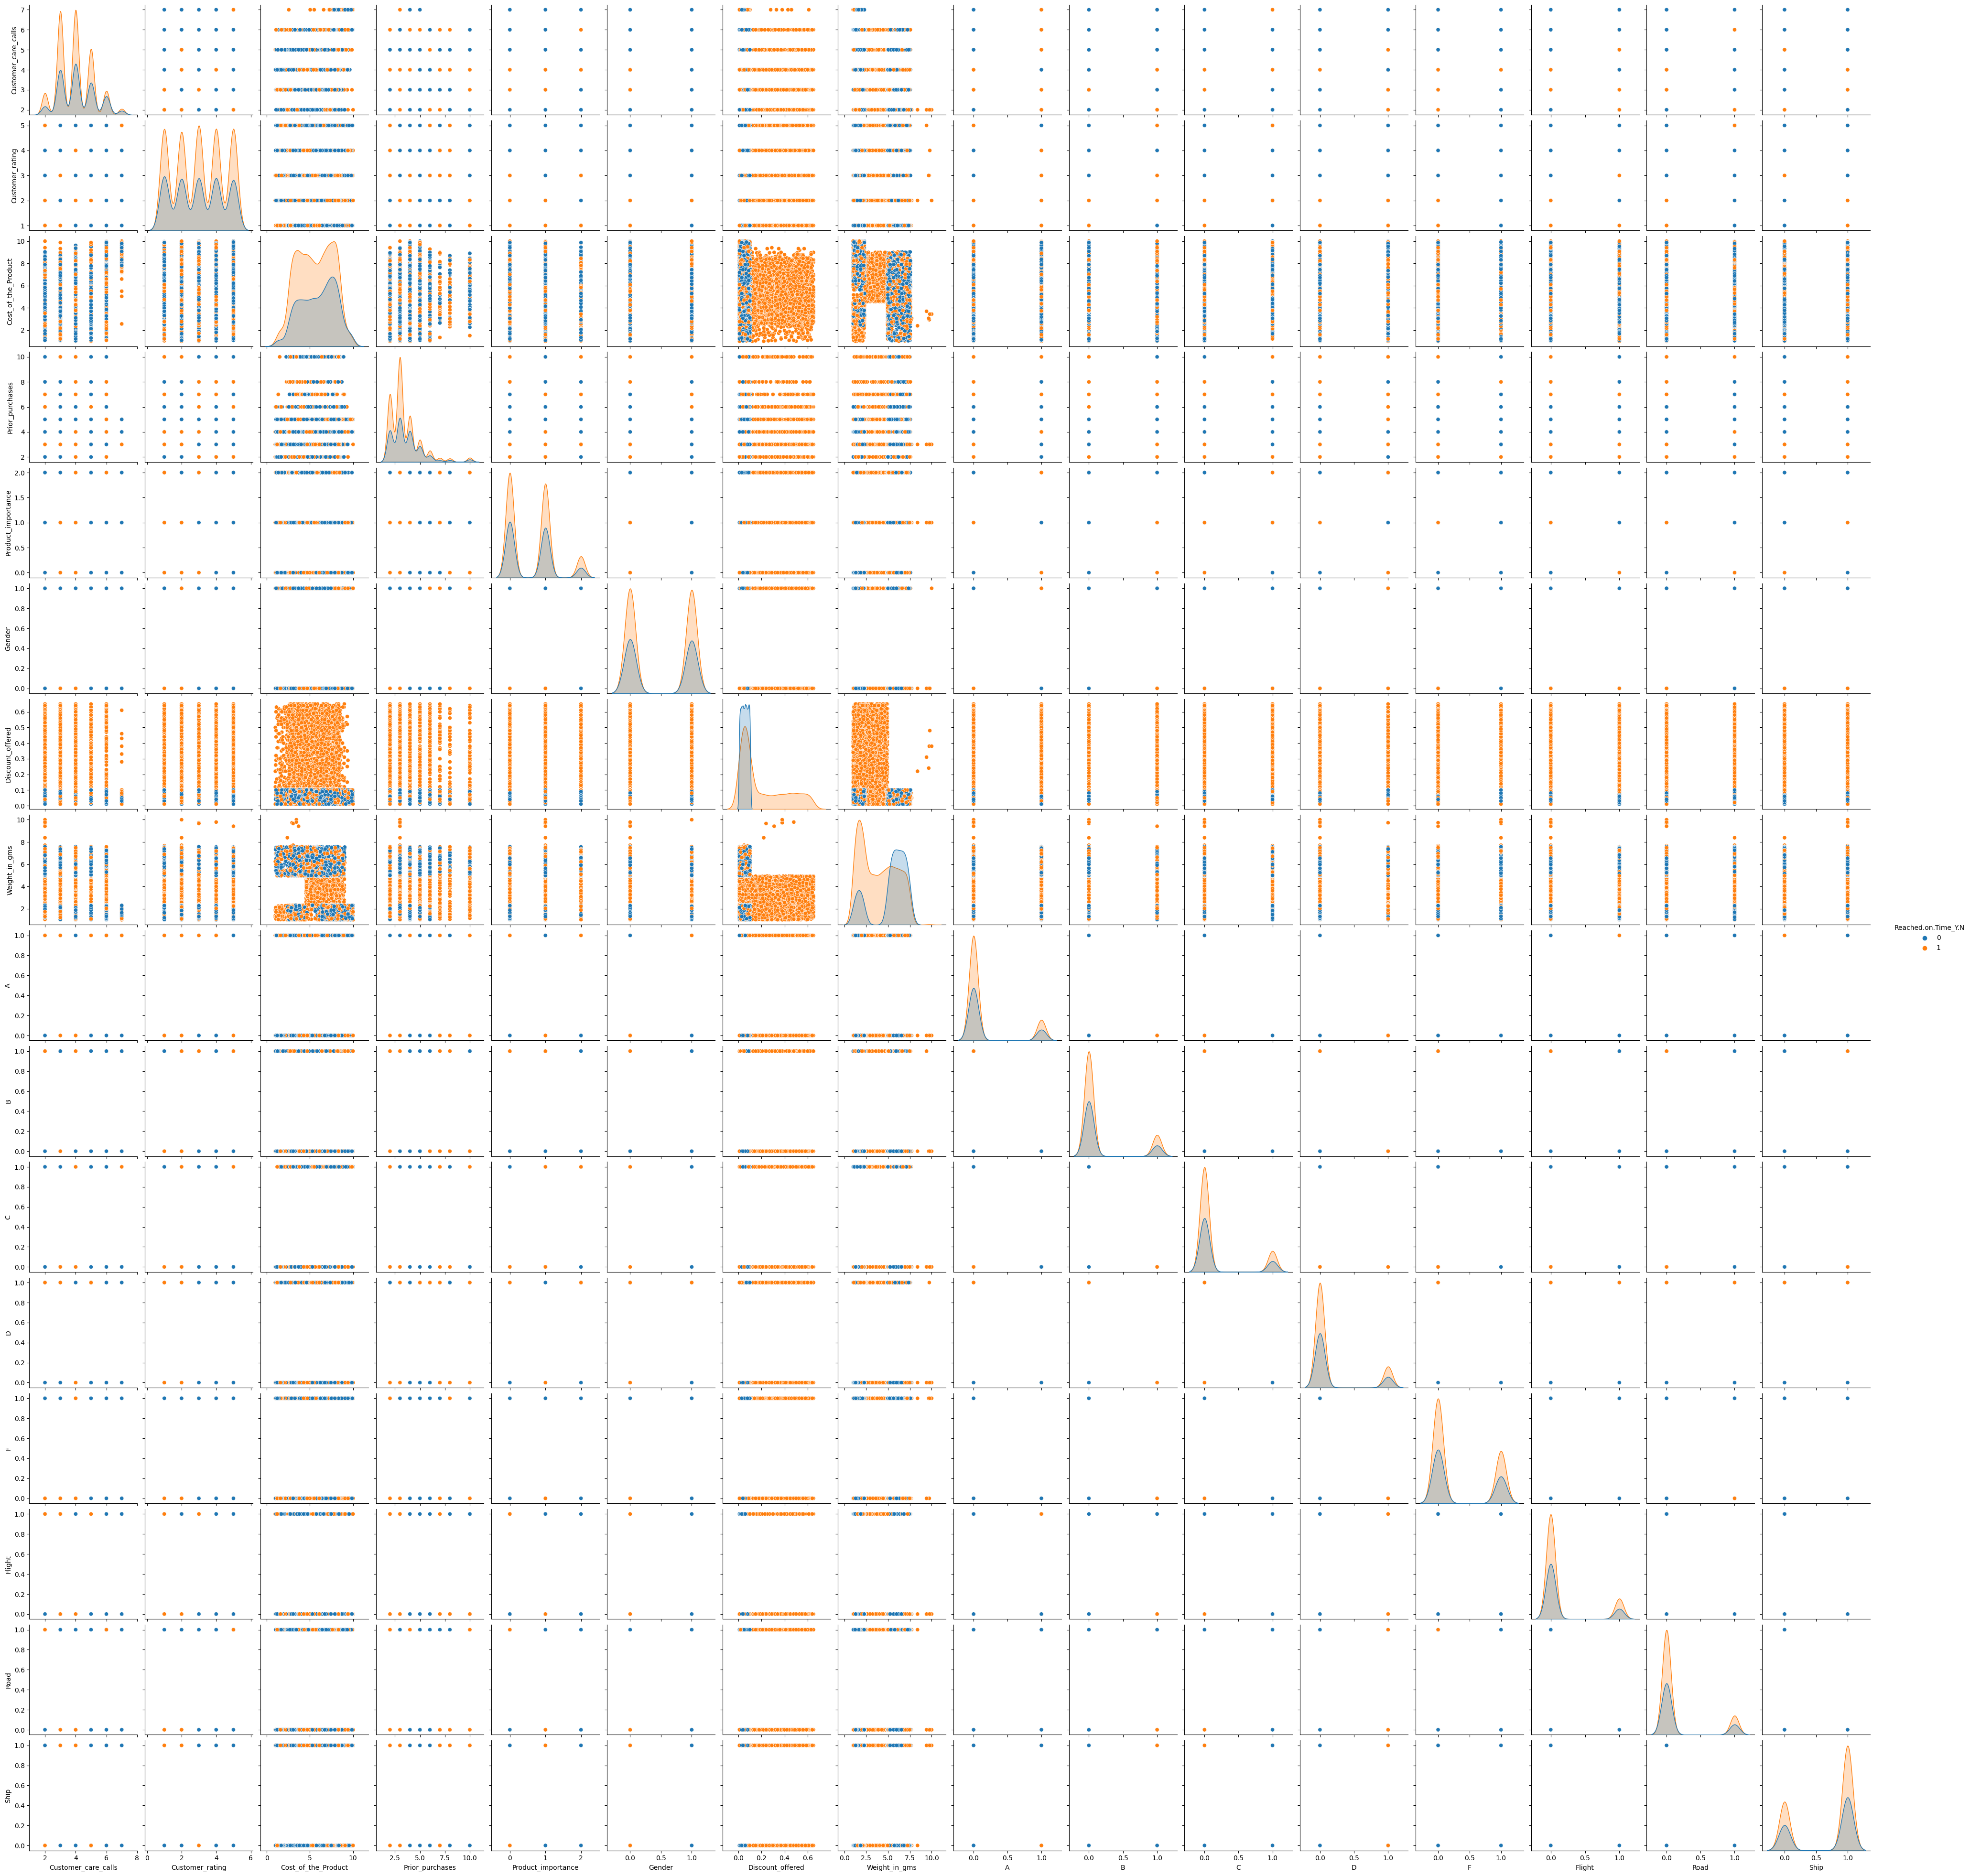

In [ ]:
sns.pairplot(datos, hue="Reached.on.Time_Y.N")

Vemos que efectivamente el Genero no es algo que infuye al momento de llegar a tiempo el pedido, pero no descartabamos la posibilidad de una empresa sexista hasta recién. Y vamos a seleccionar para trabajo únicamente los datos con una correlacion superior al 0.1.

Continuaremos ahora con la selección de [modelos de ML](MachineLearning.ipynb)